In [1]:
import gensim.downloader
from gensim.models import Word2Vec
import copy
import numpy as np
import random
from scipy.stats import spearmanr

In [2]:
#weat 6
_glove_model = gensim.downloader.load('glove-wiki-gigaword-50')
_glove_model_changed = gensim.downloader.load('glove-wiki-gigaword-50')

#careers = ['technician', 'accountant', 'supervisor', 'engineer', 'worker', 'educator', 'clerk', 'counselor', 'inspector', 'mechanic', 'manager', 'therapist', 'administrator', 'salesperson', 'receptionist', 'librarian', 'advisor', 'pharmacist', 'janitor', 'psychologist', 'physician', 'carpenter', 'nurse', 'investigator', 'bartender', 'specialist', 'electrician', 'officer', 'pathologist', 'teacher', 'lawyer', 'planner', 'practitioner', 'plumber', 'instructor', 'surgeon', 'veterinarian', 'paramedic', 'examiner', 'chemist', 'machinist', 'appraiser', 'nutritionist', 'architect', 'hairdresser', 'baker', 'programmer', 'paralegal', 'hygienist', 'scientist']
female_attributes = ['female', 'woman', 'girl', 'sister', 'she', 'her', 'hers', 'daughter']
male_attributes = ['male', 'man', 'boy', 'brother', 'he', 'him', 'his', 'son']

careers = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition', 'poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']



In [3]:
def load_dataset(filepath):
    word_pairs = []
    human_scores = []
    with open(filepath, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 3:
                word1, word2, score = parts
                score = float(score)
                word_pairs.append((word1.split('-')[0], word2.split('-')[0]))
                human_scores.append(score)
    return word_pairs, human_scores

In [4]:
filepath = 'MEN_dataset_lemma_form.dev'
word_pairs, human_scores = load_dataset(filepath)

men_words = []
for word1, word2 in word_pairs:
    men_words.append(word1)
    men_words.append(word2)

In [5]:
all_words = list(set(female_attributes + male_attributes + careers + men_words))

In [6]:
word_vectors = {word: _glove_model[word] for word in all_words if word in _glove_model}
vectors = np.array([word_vectors[word] for word in word_vectors.keys()])
words = list(word_vectors.keys())
reduced_glove = Word2Vec(vector_size=50, min_count=1)
reduced_glove.build_vocab([words])
reduced_glove.wv.vectors = vectors
reduced_glove.wv.index_to_key = words
reduced_glove.wv.key_to_index = {word: idx for idx, word in enumerate(words)}


In [21]:
POP_SIZE = 50
GEN_MAX = 100
MUT_RATE = 0.2
CROSS_RATE = 0.6

def noise_vec(_size=50):
    return np.random.uniform(-2, 2, size=_size)

#garantir que exista um vetor unitário
def init_population():
    population = np.ones((POP_SIZE - 1, 50)) + np.array([noise_vec() for _ in range(POP_SIZE - 1)])
    population = np.vstack([population, np.ones(50)])
    np.random.shuffle(population)
    return population


def selection(population, costs, _k=2):
    return random.choices(population, weights=[1 / (cost + 1) for cost in costs], k=_k)

def crossover(parent1, parent2):
    point1, point2 = sorted(random.sample(range(len(parent1)), 2))
    child1 = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.concatenate((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def mutate(child):
    if random.random() < MUT_RATE:
        child += noise_vec()
    return child

def wordembedding_similarity(word_pairs, model):
    embedding_similarities = []
    for word1, word2 in word_pairs:
        if word1 in model and word2 in model:
            similarity = model.similarity(word1, word2)
        else:
            similarity = 0.0
        embedding_similarities.append(similarity)
    return embedding_similarities

def combined_cost(s, word_pairs, human_scores, alpha=0.5):
    glove_model_modified = copy.copy(reduced_glove.wv)
    
    for _word in all_words:
        glove_model_modified[_word] = np.multiply(glove_model_modified[_word], s)
        
    differences = [
        abs(
            sum(glove_model_modified.similarity(career, attr) for attr in female_attributes) / len(female_attributes) - 
            sum(glove_model_modified.similarity(career, attr) for attr in male_attributes) / len(male_attributes)
        )
        for career in careers
    ]
    
    bias = sum(differences)

    embedding_similarities = wordembedding_similarity(word_pairs, glove_model_modified)
    spearman_corr, _ = spearmanr(human_scores, embedding_similarities)
    cost_spearman = 1 - spearman_corr
    cost = alpha * bias + (1 - alpha) * cost_spearman
    return [cost,bias,cost_spearman]

def evolutionary_algorithm(word_pairs, human_scores, alpha=0.5):
    population = init_population()
    best_individual = None
    best_cost = float('inf')
    
    for gen in range(GEN_MAX):
        costs = [combined_cost(individual, word_pairs, human_scores, alpha)[0] for individual in population]
        best_idx = np.argmin(costs)
        current_best_cost = costs[best_idx]
        current_best_individual = population[best_idx]
        
        if current_best_cost < best_cost:
            best_cost = current_best_cost
            best_individual = current_best_individual
        
        new_population = [best_individual]
        if gen % 10 == 0:
            print(f"Generation {gen}/{GEN_MAX}: Best Cost {best_cost}")
        
        while len(new_population) < POP_SIZE:
            parent1, parent2 = selection(population, costs)
            if random.random() < CROSS_RATE:
                child1, child2 = crossover(parent1, parent2)
                child1 = mutate(child1)
                child2 = mutate(child2)
                new_population.extend([child1, child2])
            else:
                new_population.extend([parent1, parent2])
        
        population = new_population[:POP_SIZE]
    
    print(f"Generation {100}/{GEN_MAX}: Best Cost {best_cost}")
    return best_individual


In [22]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
costs = []

for _alpha in alphas:
    best_vector = evolutionary_algorithm(word_pairs, human_scores, alpha=_alpha)
    costs.append(combined_cost(best_vector, word_pairs, human_scores, alpha=_alpha))

Generation 0/100: Best Cost 0.36929050854001205
Generation 10/100: Best Cost 0.3636760783537114
Generation 20/100: Best Cost 0.362430651923723
Generation 30/100: Best Cost 0.362430651923723
Generation 40/100: Best Cost 0.36029569365127
Generation 50/100: Best Cost 0.36029569365127
Generation 60/100: Best Cost 0.36029569365127
Generation 70/100: Best Cost 0.3585621879685503
Generation 80/100: Best Cost 0.35246150480865646
Generation 90/100: Best Cost 0.348153568348142
Generation 100/100: Best Cost 0.3438444309137326
Generation 0/100: Best Cost 0.4116944892004104
Generation 10/100: Best Cost 0.39641366171707615
Generation 20/100: Best Cost 0.3774773065871595
Generation 30/100: Best Cost 0.3774773065871595
Generation 40/100: Best Cost 0.3774773065871595
Generation 50/100: Best Cost 0.36435737110457334
Generation 60/100: Best Cost 0.35553016297483114
Generation 70/100: Best Cost 0.34852868944437054
Generation 80/100: Best Cost 0.34468178950190864
Generation 90/100: Best Cost 0.338378641567

In [27]:
costs

[[0.3438444309137326, 0.45816142205148935, 0.3311425430095374],
 [0.33837864156722103, 0.33593362057581544, 0.3389898968150724],
 [0.3286199676943295, 0.2633045301772654, 0.3566122980587856],
 [0.31660717209257594, 0.16314214072190225, 0.41891719300635843],
 [0.2922882942947726, 0.17715272406348959, 0.4074238645260556],
 [0.2550312755491223, 0.12109482055529952, 0.4559359580398564],
 [0.2514114465085271, 0.11429664911702275, 0.5713459737553704],
 [0.22797789289000014, 0.17370743956416845, 0.445059706193327],
 [0.12716391160293622, 0.06183868646621704, 0.7150909378334089]]

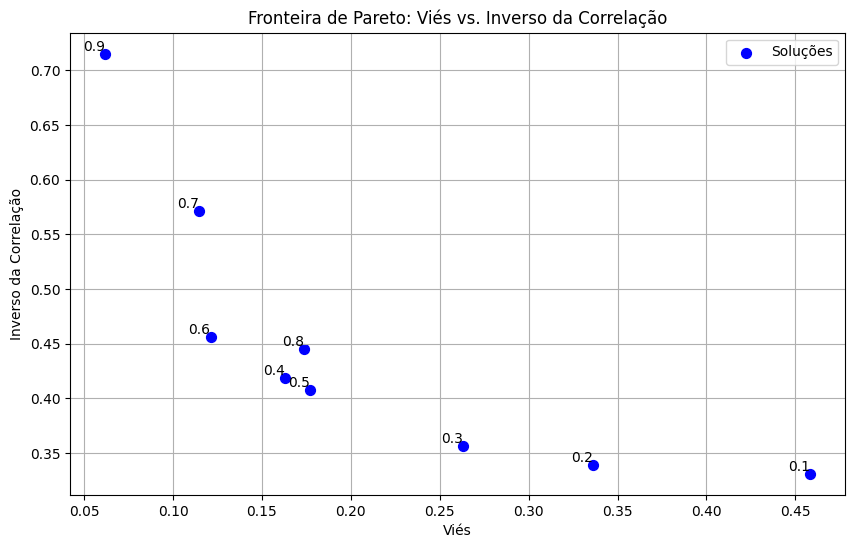

In [28]:
import numpy as np
import matplotlib.pyplot as plt

bias = [cost[1] for cost in costs]
inverse_correlation = [cost[2] for cost in costs]

plt.figure(figsize=(10, 6))
plt.scatter(bias, inverse_correlation, color='blue', s=50, label='Soluções')

for i in range(len(bias)):
    plt.text(bias[i], inverse_correlation[i], f'{(i+1)/10}', fontsize=10, ha='right', va='bottom')

plt.title('Fronteira de Pareto: Viés vs. Inverso da Correlação')
plt.xlabel('Viés')
plt.ylabel('Inverso da Correlação')
plt.grid(True)
plt.legend()
plt.show()
